## Intro

In [63]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from plotly import graph_objs as go
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot, plot
from scipy.optimize import curve_fit
import scipy.stats 
from fracture_fea_laf import postprocess
from fracture_fea_laf.postprocess import calc_sw_diff, pred_j0

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Experimental data

## Mechanical properties

In [9]:
def E_temp(T):
    """
    Calculate Young's modulus of Euromaterial A based on Serco fitting 
    
    Parameters
    ----------
    T : float
        Temperature in °C
        
    Returns
    -------
    float
        Young's modulus in MPa.    
    
    """
    return -90 * T + 206000

def s0(T):
    """
    Calculate Yield stress of Euromaterial A based on Serco fitting 
    
    Parameters
    ----------
    T : float
        Temperature in °C
        
    Returns
    -------
    float
        Yield stress in MPa.    
    
    """
    return 421.18 + 63.9 * np.exp(- T / 91)

nu = 0.3
davg = 9e-9

## Fracture toughness

In [10]:
# Load data and calculate CDF
with open(r'..\exp-data\raw_frac_data.pickle', 'rb') as handle:
    raw_frac_data = pickle.load(handle)
    
sflow = [848.5, 723.6, 683.5, 663.0]
temps = [ -154, -91, -60, -40, -20, 0]

j_exp_1, cpf_1 = postprocess.calc_cpf(raw_frac_data['1w']['t_-154']['j'])
j_exp_2, cpf_2 = postprocess.calc_cpf(raw_frac_data['1w']['t_-91']['j'])
j_exp_3, cpf_3 = postprocess.calc_cpf(raw_frac_data['1w']['t_-60']['j'])
j_exp_4, cpf_4 = postprocess.calc_cpf(raw_frac_data['1w']['t_-40']['j'])




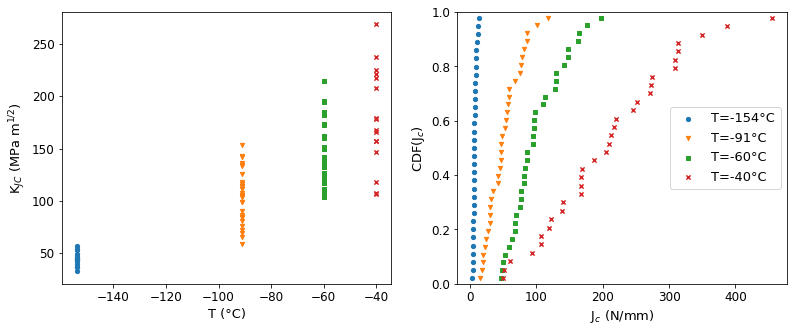

In [11]:
# plot
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(13,5));

mar = ['o','v','s','x',]
i=0
for key, val in raw_frac_data['1w'].items():
    if key != 't_-20':
        ti = int(key[2:])
        kj = np.array(val['kj_v']).flatten()
        kj = kj[np.where(kj != -1)[0]]
        t_all = np.repeat(ti, len(kj))
        ax1.scatter(t_all, kj, marker=mar[i], s=18)
        i += 1
ax1.set_ylabel('K$_{JC}$ (MPa m$^{1/2}$)', fontsize=13)
ax1.set_xlabel('T (°C)', fontsize=13)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)
        
ax2.scatter(j_exp_1, cpf_1, label='T=-154°C', marker='o', s=18)
ax2.scatter(j_exp_2, cpf_2, label='T=-91°C',  marker='v', s=18)
ax2.scatter(j_exp_3, cpf_3, label='T=-60°C',  marker='s', s=18)
ax2.scatter(j_exp_4, cpf_4, label='T=-40°C',  marker='x', s=18)
ax2.set_xlabel('J$_c$ (N/mm)', fontsize=13)
ax2.set_ylabel('CDF(J$_c$)', fontsize=13)
ax2.set_ylim([0,1])
ax2.xaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=12)
ax2.legend(fontsize=13, loc=5)
f.savefig('exp_data.png', bbox_inches='tight', dpi=300)

## Calculate Weibull fits

7.543057338566327
 57.62462988888352
 112.32615771117054
 236.79391517405494



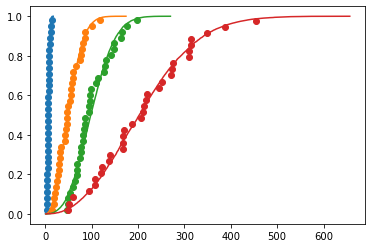

In [12]:
a_out, Kappa_out, loc_out, Lambda_out = scipy.stats.exponweib.fit(j_exp_1,floc=0,f0=1)
j_fit_unsorted = scipy.stats.exponweib.rvs(a=a_out,c=Kappa_out, loc=loc_out, scale=Lambda_out, size = 100000)

j_1_fit, cpf_1_fit = postprocess.calc_cpf(j_fit_unsorted)

a_out, Kappa_out, loc_out, Lambda_out = scipy.stats.exponweib.fit(j_exp_2, floc=0,f0=1)
j_fit_unsorted = scipy.stats.exponweib.rvs(a=a_out,c=Kappa_out, loc=loc_out, scale=Lambda_out, size = 10000)
j_2_fit, cpf_2_fit = postprocess.calc_cpf(j_fit_unsorted)


a_out, Kappa_out, loc_out, Lambda_out = scipy.stats.exponweib.fit(j_exp_3, floc=0,f0=1)
j_fit_unsorted = scipy.stats.exponweib.rvs(a=a_out,c=Kappa_out, loc=loc_out, scale=Lambda_out, size = 10000)
j_3_fit, cpf_3_fit = postprocess.calc_cpf(j_fit_unsorted)


a_out, Kappa_out, loc_out, Lambda_out = scipy.stats.exponweib.fit(j_exp_4, floc=0,f0=1)
j_fit_unsorted = scipy.stats.exponweib.rvs(a=a_out,c=Kappa_out, loc=loc_out, scale=Lambda_out, size = 10000)
j_4_fit, cpf_4_fit = postprocess.calc_cpf(j_fit_unsorted)


j0_1 = postprocess.find_closest(cpf_1_fit, j_1_fit, 0.632, 0.001)[1][0]
j0_2 = postprocess.find_closest(cpf_2_fit, j_2_fit, 0.632,  0.001)[1][0]
j0_3 = postprocess.find_closest(cpf_3_fit, j_3_fit, 0.632,  0.001)[1][0]
j0_4 = postprocess.find_closest(cpf_4_fit, j_4_fit, 0.632,  0.001)[1][0]

print(
    str(j0_1) + '\n' ,
    str(j0_2) + '\n' ,
    str(j0_3) + '\n' ,
    str(j0_4) + '\n' ,
)
j0_all_temps = [j0_1,
j0_2,
j0_3,
j0_4,]


plt.scatter(j_exp_1, cpf_1, label='T=-154 °C')
plt.plot( j_1_fit, cpf_1_fit)

plt.scatter(j_exp_2, cpf_2, label='T=-91 °C')
plt.plot(j_2_fit, cpf_2_fit)

plt.scatter(j_exp_3, cpf_3, label='T=-60 °C')
plt.plot(j_3_fit, cpf_3_fit)

plt.scatter(j_exp_4, cpf_4, label='T=-40 °C')
plt.plot(j_4_fit, cpf_4_fit)

# Model

## Load FE data

In [13]:
# index of active calculation
act_idx = [1, 1, 1]

paths = np.array([
     r'..\fea-data\ct-3d-fan\ct91',
     r'..\fea-data\ct-3d-fan\ct60', 
     r'..\fea-data\ct-3d-fan\ct40'
    ])[np.where(act_idx)]

temps = np.array([-91, -60, -40])[np.where(act_idx)]
radii = np.array([10, 15, 30])[np.where(act_idx)]

filesg = np.array([r'ct91_ghis.txt', r'ct60_ghis.txt', r'ct40_ghis.txt'])[np.where(act_idx)]
filese = np.array([r'ct91_ehis.txt', r'ct60_ehis.txt', r'ct40_ehis.txt'])[np.where(act_idx)]
file_labs = np.array([r'ct91', r'ct60', r'ct40'])[np.where(act_idx)]

s0_all_temps = s0(np.array(temps))
j0_all = np.array(j0_all_temps)[1:][np.where(act_idx)]

In [14]:
j0_all

array([ 57.62462989, 112.32615771, 236.79391517])

In [15]:
# Read data from ghis file and find J values closest to J0
gdata_all = []
for i, path in enumerate(paths):
    print('\n', path)

    file_path = os.path.join(path, filesg[i])
    data_path = pd.read_csv(file_path, sep=' ', skiprows=1, index_col=False,  
                    names=[ 'iframe','jintc', 'ctod', 'sqrt(rpz)', 'vpz', 'smax', 'pmax','peeq'])

    jdata = data_path['jintc']
    j0_idx = postprocess.find_nearest(jdata, j0_all[i])

    j0_close = jdata[j0_idx]

    gdata_all.append(
        {
            'file_path': file_path,
            'gdata': data_path,
            'j0_idx': j0_idx,
            'j0': j0_close,


        }
    )
    
    print('Characteristic J0: ', jdata[j0_idx])
    print('Time increment of J0: ', j0_idx)



 ..\fea-data\ct-3d-fan\ct91
Characteristic J0:  58.6458435059
Time increment of J0:  45

 ..\fea-data\ct-3d-fan\ct60
Characteristic J0:  113.964439392
Time increment of J0:  64

 ..\fea-data\ct-3d-fan\ct40
Characteristic J0:  236.860244751
Time increment of J0:  63


## Crack fronts

In [16]:
# %%time

data_labels = ['label', 'xcoord', 'ycoord', 'zcoord','vol', 's1',
               's2', 's3', 'p1', 'p2', 'p3', 'peeq', 'sh', 'seq']
front_data_all = []
skipped_lines_all = []

for ip, path in enumerate(paths):
    file_path = os.path.join(path, file_labs[ip] +  r'_front.txt')
    front_data_all.append({
        'file_path': file_path,
        'data': {},
    })
    curr_line = 0
    skipped_lines = 0
    dwp = 0
    dwv = 0
    rtrat = 0
    with open(file_path, 'rb') as file:
        all_lines = file.readlines()
        num_frames = int(all_lines[0].strip())
        front_data_all[ip]['data'] = []
        curr_line += 1
        labels_0 = pd.Series(dtype='float64')
        smax_0 = pd.Series(dtype='float64')
        data_0 = 0
        k = 0
        for ti in range(num_frames):
#             print('step:', ti)
            frame_i, num_elem_i = [int(n) for n in all_lines[curr_line].strip().split()]
            if num_elem_i == 0:
                skipped_lines += 1
            elif num_elem_i > 0:
                skip_rows = list(range(0, curr_line+1))
                data_i = pd.read_csv(file_path, sep=' ', skiprows=skip_rows,index_col=False,
                                     nrows=num_elem_i, names=data_labels)

                labels_i = data_i['label']
                pl_elem_check = labels_i.isin(labels_0)
                smax_i = np.max(data_i[['s1', 's2', 's3']], axis=1)
                vols_i = data_i['vol']
                smin_i = np.min(data_i[['s1', 's2', 's3']], axis=1)
                pmax_i = np.max(data_i[['p1', 'p2', 'p3']], axis=1)
                seq_i = data_i['seq'].values
                sh_i = data_i['sh'].values
                smax_i_allt = smax_i.copy()
            
                smax_i_allt[labels_i.isin(labels_0)] = np.max([smax_0.values, 
                                                          smax_i_allt[labels_i.isin(labels_0)].values], 
                                                          axis=0)
                peeq_0 = np.zeros(len(labels_i))
                wp_i = np.zeros(len(labels_i))
                wv_i = np.zeros(len(labels_i))
                sum_rtrat_i = np.zeros(len(labels_i))
                
                
                if type(data_0) == pd.core.frame.DataFrame:
                    
                    peeq_0[labels_i.isin(labels_0)] = data_0['peeq']
                    dpeeq = data_i['peeq'].values - peeq_0
                    
                    if k >= 1:
                        wp_i[labels_i.isin(labels_0)] = wp_0
                        wv_i[labels_i.isin(labels_0)] = wv_0
                        sum_rtrat_i[labels_i.isin(labels_0)] = sum_rtrat_0
                    
                    dwp = seq_i * dpeeq * (10 ** (-3))  # plastic flow work
#                     dwv = 3 * 0.427 * (-sh_i / seq_i) * np.exp(
#                           3 * sh_i / (2 * seq_i)
#                           ) * dwp   # voids growth work
                    
                    striax = sh_i / seq_i
                    deps_kkp = 3 * 0.427 * np.exp(3 * striax / 2) * dpeeq
                    dwv = - sh_i * deps_kkp * (10 ** (-3))
                    
                    rtrat = deps_kkp / 3
                    
                    wp_i = wp_i + dwp
                    wv_i = wv_i + dwv
                    sum_rtrat_i = sum_rtrat_i + rtrat
                    
                    k += 1

                
                front_data_all[ip]['data'].append({
                    'frame_i': frame_i,
                    'num_elem_i': num_elem_i,
                    'elem_labels': data_i['label'],
                    'xcoord': data_i['xcoord'],
                    'smax': smax_i,
                    'smin': smin_i,
                    'smaxallt': smax_i_allt,
                    'sh':  sh_i,
                    'seq':  seq_i,
                    'vol': vols_i,
                    'peeq': data_i['peeq'],
                    'p1': data_i['p1'],
                    'p2': data_i['p2'],
                    'p3': data_i['p3'],
                    'pmax': pmax_i,
                    'dwp': dwp,
                    'dwv': dwv,
                    'wp': wp_i,
                    'wv': wv_i,
                    'rtrat': rtrat,
                    'sum_rt_rat': sum_rtrat_i
                })

                labels_0 = labels_i
                smax_0 = smax_i_allt
                data_0 = data_i
                wp_0 = np.copy(wp_i)
                wv_0 = np.copy(wv_i)
                sum_rtrat_0 = np.copy(sum_rtrat_i)

            curr_line += num_elem_i + 1
    skipped_lines_all.append(skipped_lines)

In [17]:
# code
cols = ['black', 'blue', 'green', 'red']
def plot_front(data_all, iframes, xparam, yparam, norm_factors=None,
              xrange=None, yrange=None, ylog=False, ylab=None, plot_lim=None,
              xlab=r'$\LARGE{r * \sigma_0 / J}$'):    
    data = []
    for i, d in enumerate(data_all):
#         print(i, iframes[i])
        xdata = d['data'][iframes[i]][xparam]
        ydata = d['data'][iframes[i]][yparam]
        
        if type(norm_factors) == list:
            xdata = xdata * norm_factors[0][i]
            ydata = ydata / norm_factors[1][i]
#             print(norm_factors[0][i])
#             print(norm_factors[1][i])
        if plot_lim:
            plot_idx_y = np.where(ydata>=plot_lim)[0]
            plot_idx_x= np.where(xdata<=xrange[1])[0]
            plot_idx = np.intersect1d(plot_idx_x, plot_idx_y)
            
            xdata = xdata[plot_idx]
            ydata = ydata[plot_idx]
        
        if i == 4:
            data.append({
                 'x': xdata,
                 'y': ydata,
                   'name': 'T = -' + file_labs[i][2:] + '°C-lc',
                    #'marker':{'symbol':'circle', 'color': [ri], 'colorscale': 'Viridis'},
                    'line': {'width': 1.5, 'color': cols[i]},
                'mode': 'lines'
            })
        else:
            data.append({
                 'x': xdata,
                 'y': ydata,
                   'name': 'T = -' + file_labs[i][2:] + '°C',
                    #'marker':{'symbol':'circle', 'color': [ri], 'colorscale': 'Viridis'},
                    'line': {'width': 1.5, 'color': cols[i]},
                'mode': 'lines'
            })


    layout = {
            'width': 450,
            'height': 400,
         'margin': {
                'l': 80,
                'r': 20,
                'b': 80,
                't': 20,
#                 'pad': 1
     },
            'xaxis': {
        #         'range': [-0.1, 1.1],
                'zeroline': False,
                'showline': True,
                'mirror': 'all',
                 'dtick': 0.5,
                'tickformat': ".1f"
    #             'title': r'$r * \sigma_0 / J$',
            },
            'yaxis': {
                'zeroline': False,
                'showline': True,
                'mirror': 'all',
    #             'title': ylab,
                'tickformat' : '.2f',
               
            },
             'annotations':[
        {
            'text':  xlab,
            'x': 0.5,
            'y': -0.22,
            'xref': 'paper',
            'yref': 'paper',
            'showarrow': False,
            'font': {'size': 13},
        },
            {
            'text':  ylab,
            'x': -0.22,
            'y': 0.5,
            'xref': 'paper',
            'yref': 'paper',
            'showarrow': False,
            'font': {'size': 13},
            'textangle': -90
        },
                  
        ],
            'legend':{
            'x': 0.5,
            'y': 0.65, # 0.06; 
        },
    }
    if xrange:
        layout['xaxis']['range'] = xrange
    if yrange:
        layout['yaxis']['range'] = yrange
    if ylog:
        layout['yaxis']['type'] = 'log'
        layout['yaxis']['tickformat'] =  ''
#         layout['yaxis']['dtick'] =  1
        layout['yaxis']['tickvals'] = np.concatenate([
                                    np.linspace(1, 9, 9),
                                    np.linspace(10, 90, 9),
                                    np.linspace(100, 900, 9),
                                    [1000]
                                ]) / 1000
        layout['yaxis']['ticktext'] = ['0.001','','','','','','','','',
                                       '0.01','','','','','','','','',
                                       '0.1','','','','','','','','','1','']
    else:
        layout['yaxis']['dtick'] = 0.2
        layout['yaxis']['tickformat'] = '.1f'

    layout['showlegend'] = True
#     iplot(go.Figure(data=data, layout=layout))
    f = go.FigureWidget(data,layout)
    return f
    

# plot
xcorr = []

for ti, temp in enumerate(temps):
    xcorr.append(
        s0(temp) / gdata_all[ti]['gdata']['jintc'][gdata_all[ti]['j0_idx']]
    )

n = len(paths)
j0_idx_all = np.array([gdata_all[ti]['j0_idx'] for ti in range(n)]) - np.array(skipped_lines_all)
plot_lim=0.002

plot_idx_y = []
for i, d in enumerate(front_data_all):
    plot_idx_y.append(np.where(d['data'][j0_idx_all[i]]['peeq']>=plot_lim)[0])


### Equivalent plastic strain

In [21]:
# plastic strain

f = plot_front(front_data_all, 
            np.array([gdata_all[ti]['j0_idx'] for ti in range(n)]) - np.array(skipped_lines_all),
           'xcoord', 'peeq',  [xcorr, np.ones(n)],
           xrange=[-0.05, 4.05], yrange=[np.log(0.04), np.log(1.7)], ylog=True,
          ylab=r'$\LARGE{\varepsilon_{\textrm{eq}}^\textrm{p}}$', xlab = r'r (mm)',
#                plot_lim=0.002
              )

py.iplot(f)
# pio.write_image(f, 'images/fig5.svg',width=450, height=400,)\


### Maximum principal stress

In [20]:
# Max stress
f = plot_front(front_data_all,
               np.array([gdata_all[ti]['j0_idx'] for ti in range(n)]) - np.array(skipped_lines_all),
           'xcoord', 'smax', 
               [xcorr, [s0(t) for t in temps]],
#                [np.ones(4), [s0(t) for t in temps]],
               xrange=[-0.05, 4.05], yrange=[1.6, 4.05], 
               ylab=r'$\LARGE{\sigma_\mathrm{I}/\sigma_0}$',
               xlab = r'r (mm)',)
py.iplot(f)

## Weibull stress calculation

### Extract data

In [24]:
# code

data_labels = ['label', 'xcoord', 'ycoord', 'zcoord','vol', 's1', 's2', 's3', 'p1', 'p2', 'p3', 'peeq', 'sh', 'seq']
sw_data_all = []
skipped_lines_all = []
for ip, path in enumerate(paths):

    file_path = os.path.join(path, filese[ip])
    print(file_path)
    sw_data_all.append({
            'file_path': file_path,
            'data': {},
        })


    curr_line = 0
    skipped_lines = 0

    with open(file_path, 'rb') as file:
        all_lines = file.readlines()
        num_frames = int(all_lines[0].strip())
        sw_data_all[ip]['data'] = []
        curr_line += 1
        labels_0 = pd.Series(dtype='float64')
        smax_0 =  pd.Series(dtype='float64')
        data_0 = 0
        k = 0
        for ti in range(num_frames):
#         for ti in range(5):
            frame_i, num_elem_i = [int(n) for n in all_lines[curr_line].strip().split()]

            if num_elem_i == 0:
                skipped_lines += 1
            elif num_elem_i > 0:
#                 print(frame_i, num_elem_i)
                skip_rows = list(range(0, curr_line+1))
                data_i = pd.read_csv(file_path, sep=' ', skiprows=skip_rows, index_col=False,
                                     nrows=num_elem_i, names=data_labels)

                labels_i = data_i['label']
                pl_elem_check = labels_i.isin(labels_0)
                x_i = data_i['xcoord']
                y_i = data_i['ycoord']
                z_i = data_i['zcoord']
                smin_i = np.min(data_i[['s1', 's2', 's3']], axis=1)
                smax_i = np.max(data_i[['s1', 's2', 's3']], axis=1)
                pmax_i = np.max(data_i[['p1', 'p2', 'p3']], axis=1)
                vols_i = data_i['vol']
                peeq_i = data_i['peeq']
                sh_i = data_i['sh']
                seq_i = data_i['seq']

                smax_i_allt = smax_i.copy()
                smax_i_allt[labels_i.isin(labels_0)] = np.max([smax_0.values[np.where(labels_0.isin(labels_i))], 
                                                          smax_i_allt[labels_i.isin(labels_0)].values], axis=0)

                peeq_0 = np.zeros(len(labels_i))


                sw_data_all[ip]['data'].append({
                    'frame_i': frame_i,
                    'num_elem_i': num_elem_i,
                    'elem_labels': labels_i,
                    'xcoord': x_i,
                    'ycoord': y_i,
                    'zcoord': z_i,
                    'smax': smax_i,
                    'smin': smin_i,
                    'smaxallt': smax_i_allt,
                    'vol': vols_i,
                    'peeq': peeq_i,
                    'pmax': pmax_i,
                })


                labels_0 = labels_i.copy()
                smax_0 = smax_i_allt.copy()
                data_0 = data_i


            curr_line += num_elem_i + 1
        skipped_lines_all.append(skipped_lines)

..\fea-data\ct-3d-fan\ct91\ct91_ehis.txt
..\fea-data\ct-3d-fan\ct60\ct60_ehis.txt
..\fea-data\ct-3d-fan\ct40\ct40_ehis.txt


### Original Beremin

In [25]:
# USER INPUT
sy_cut = 2
plastic_strain_offset = 0.002
unit_volume = (4 / 3) * np.pi * (10 * 1e-3) ** 3

In [26]:
# code

m_vals = np.arange(5, 26, 1)
v0s = unit_volume * np.ones(len(paths))
glob_sw_all = []
for ip, path in enumerate(paths):
    print('path: ', path)
    glob_sw_all.append([])
    num_frames = len(sw_data_all[ip]['data'])
#     print(num_frames)
    sy_ip = s0_all_temps[ip]
    print('Yield stress: ', sy_ip)
    for m in m_vals:
        glob_sw = []
        
        for ti in range(num_frames):
            data_i = sw_data_all[ip]['data'][ti]
            peeq_i = data_i['peeq']
            smax_i = data_i['smaxallt']
            vols_i = data_i['vol']
            pcut_idx = np.where(peeq_i>=plastic_strain_offset)[0]
            scut_idx = np.where(smax_i>=(sy_cut*sy_ip))[0]
            combcut_idx = np.intersect1d(pcut_idx, scut_idx)
            
            loc_sw_i = (smax_i.values ** m) * vols_i.values

            loc_sw_i = loc_sw_i[combcut_idx]
            glob_sw.append((sum(np.array(loc_sw_i)) / v0s[ip]) ** (1. / m))


        glob_sw_all[ip].append(glob_sw)


path:  ..\fea-data\ct-3d-fan\ct91
Yield stress:  594.878208838533
path:  ..\fea-data\ct-3d-fan\ct60
Yield stress:  544.7317406204324
path:  ..\fea-data\ct-3d-fan\ct40
Yield stress:  520.35438854274


### Weibull stress vs Shape parameter `m`

In [27]:
# non-normalised Weibull

data = []
lines = ['solid','dash']
ylab =  r'$\LARGE{\sigma_\mathrm{w}}\;\textrm{(MPa)}$ '

for ri, sw_r in enumerate(glob_sw_all):
    temp_ri = temps[ri]
    x_plot = []
    y_plot = []
    for mi, sw in enumerate(sw_r):                
        x_plot.append(m_vals[mi])
        y_plot.append(sw[gdata_all[ri]['j0_idx']-np.array(skipped_lines_all)[ri]])

        if mi == 0:
            print(gdata_all[ri]['j0'])
    data.append({
            'x': x_plot,
            'y': np.array(y_plot) ,
#             'name': file_labs[ri],
            'name': r'T = ' + str(temps[ri]) + r'°C',
#             'name': str(num_el[ri]) + ' elements',
#             'name': paths[ri][18:],
#             'name': str(radii[ri]) + ' μm',
            'line': {'dash': lines[0], 'color': cols[ri], 'width': 2},
             'mode': 'lines',
        })
  

layout = {
    'width': 450,
    'height': 420,
    'xaxis': {
#         'range': [-0.1, 1.1],
        'zeroline': False,
        'showline': True,
        'mirror': 'all',
#         'title': r'$m$',
        'titlefont':{'size': 13}
    },
    'yaxis': {
        'zeroline': False,
        'showline': True,
        'mirror': 'all',
#         'title': '$\sigma_\mathrm{w}/\sigma_\mathrm{f} $ ',
        'titlefont':{'size': 13},

    },
    'annotations':[
    {
        'text':  r'$\LARGE{m}$',
        'x': 0.5,
        'y': -0.2,
        'xref': 'paper',
        'yref': 'paper',
        'showarrow': False,
        'font': {'size': 11},
    },
        {
        'text': ylab,
        'x': -0.2,
        'y': 0.5,
        'xref': 'paper',
        'yref': 'paper',
        'showarrow': False,
        'font': {'size': 11},
        'textangle': -90
    },
    ],
    'legend':{
        'x': 0.6,
        'y': 0.7,
    },
     'margin': {
                'l': 80,
                'r': 20,
                'b': 80,
                't': 40,
#                 'pad': 1
     },

}
layout['xaxis']['range'] = [5, 25]
# layout['yaxis']['range'] = [-0.1, 1]
layout['showlegend'] = True
f = go.FigureWidget(data,layout)
py.iplot(f)
# pio.write_image(f, 'images-jan2020/fig6.svg',width=450, height=400,)

58.6458435059
113.964439392
236.860244751


### Delta Weibull stress vs Shape parameter `m`

$\Large{\Delta \sigma_W = \frac{\sigma_{-91°C} - \sigma_{T_i}}{\sigma_{-91°C}} 100}$



In [30]:
# plot

title = r''
ylab = r'$\LARGE{ \Delta \sigma_\mathrm{w} (\%)}$'

data = []
for ri, sw_r in enumerate(glob_sw_all):

    x_plot = []
    y_plot = []

    for mi, sw in enumerate(sw_r):
        x_plot.append(m_vals[mi])
        y_plot.append(
            calc_sw_diff(glob_sw_all, 0, ri, mi, gdata_all, skipped_lines_all) 
            )
        data.append({
            'x': x_plot,
            'y': y_plot,
            'name': r'T = ' + str(temps[ri]) + r'°C',
            'line': {'dash': lines[0], 'color': cols[ri], 'width': 2},
            'mode': 'lines',
        })

        

layout = {
    'width': 450,
    'height': 420,
    'xaxis': {
#         'range': [-0.1, 1.1],
        'zeroline': False,
        'showline': True,
        'mirror': 'all',
#         'title': r'$m$',
        'titlefont':{'size': 13}
    },
    'yaxis': {
        'zeroline': False,
        'showline': True,
        'mirror': 'all',
#         'title': '$\sigma_\mathrm{w}/\sigma_\mathrm{f} $ ',
        'titlefont':{'size': 13},

    },
    'annotations':[
    {
        'text':  r'$\LARGE{m}$',
        'x': 0.5,
        'y': -0.2,
        'xref': 'paper',
        'yref': 'paper',
        'showarrow': False,
        'font': {'size': 18},
    },
        {
        'text':  ylab,
        'x': -0.2,
        'y': 0.5,
        'xref': 'paper',
        'yref': 'paper',
        'showarrow': False,
        'font': {'size': 18},
        'textangle': -90
    },
        {
        'text':  title,
        'x': 0.41,
        'y': 1.1,
        'xref': 'paper',
        'yref': 'paper',
        'showarrow': False,
        'font': {'size': 18},
    },
    ],
    'legend':{
        'x': 0.6,
        'y': 0.5,
    },
     'margin': {
                'l': 80,
                'r': 20,
                'b': 80,
                't': 40,
#                 'pad': 1
     },

}
layout['xaxis']['range'] = [5, 25]
layout['showlegend'] = False
f = go.FigureWidget(data,layout)
py.iplot(f)
# pio.write_image(f, 'images/fig9.svg',width=450, height=400,)

### Predict the caharcteristic fracture toughness $J_0$

In [71]:
# USER INPUT
# Choose shape parameter m
mchosen = 5

# Choose index basis for prediction 
# For inctance, to use the first temperature as a basis, we specify 0 (due to zero-based indexing)
pred_index = 0

idxm = np.where(m_vals==mchosen)[0][0]
print(pred_j0(pred_index, glob_sw_all, idxm, skipped_lines_all, 
              gdata_all, temps, tol=0.01))

Weibull stress:  31226.384523906443
gdata_all[pred_i] 58.6458435059
Temperature:  -91
basis for prediction
###
Temperature:  -60
shift_idx:  3
   sw values:  [31315.59551135]
[63.43734741]
   jpred: 63.44
###
Temperature:  -40
shift_idx:  2
   sw values:  [31048.13869867]
[65.25363922]
   jpred: 65.25
###
None


In [59]:
temps

array([-91, -60, -40])

In [56]:
glob_sw_all

[[[0.0,
   0.0,
   4027.1473484067064,
   4540.924076557897,
   6381.913790597184,
   6921.862263237933,
   7746.534719767357,
   8492.894442409417,
   9401.888763399458,
   9954.656995596762,
   10810.29768071326,
   11543.471155160076,
   12169.1228909505,
   13006.22293830454,
   13575.21624790443,
   14159.466801136796,
   14860.595099971928,
   15580.82182962721,
   16300.447584137302,
   16881.566672781435,
   17567.767908968508,
   18377.16163224874,
   18772.174288527014,
   19676.554031586173,
   20176.330658376704,
   20871.77201467581,
   21344.519279325836,
   22275.28948728142,
   22661.552836183357,
   23358.585505855055,
   23954.546507264044,
   24406.074217735193,
   25270.08182884875,
   25690.82814815875,
   26203.62410653192,
   26968.704117506815,
   27372.976294607764,
   27937.284276602724,
   28616.327848943398,
   29047.39792067934,
   29640.912499435057,
   30245.395693769013,
   30690.817605236367,
   31226.384523906443,
   31754.473535798385,
   32313.710049

In [48]:
# plot
# non-normalised

ylab = r'$\LARGE{\sigma_\mathrm{w}}$'
xlab = r'$\LARGE{J\;\mathrm{(Nmm)}^{-1}}$'
# ylab = r'$\LARGE{(\sigma_\mathrm{w}/\sigma_\mathrm{u})^m }$'
layout['annotations'][1]['text'] = ylab
title = r'$$'
data = []

sw_data_plot = glob_sw_all #glob_sw_all_corr

for ri, sw_r in enumerate(sw_data_plot):
    sw = sw_r[idxm]
    mi = idxm
   
    x_plot = (gdata_all[ri]['gdata']['jintc']).values[skipped_lines_all[ri]:]
    y_plot = sw # / su_all[ri] 
    

    data.append({
            'x': x_plot,
            'y': np.array(y_plot),   # /mean_corr[ri]
            'name': r'T = ' + str(temps[ri]) + r'°C',
        #             'marker':{'symbol':'circle', 'color': [ri]},
            'line': {'dash': lines[0], 'color': cols[ri], 'width': 2},
             'mode': 'lines',
        })
data.append(
    {
        'x': np.linspace(0, 450),
        'y': sw_data_plot[1][idxm][gdata_all[1]['j0_idx']-skipped_lines_all[1]]  * np.ones(120), # / su_all[1],
        'line': {'dash': lines[1], 'color': 'grey'},
        'name': r'$\mathrm{prediction\;based\;on}\;J_0^{T = -91\mathrm{°C}}$' 
            })


layout = {
    'width': 400,
    'height': 350,
    'xaxis': {
#         'range': [-0.1, 1.1],
        'zeroline': False,
        'showline': True,
        'mirror': 'all',
#         'title': r'$m$',
        'titlefont':{'size': 13}
    },
    'yaxis': {
        'zeroline': False,
        'showline': True,
        'mirror': 'all',
#         'title': '$\sigma_\mathrm{w}/\sigma_\mathrm{f} $ ',
        'titlefont':{'size': 13},

    },
    'annotations':[
    {
        'text':  xlab,
        'x': 0.5,
        'y': -0.22,
        'xref': 'paper',
        'yref': 'paper',
        'showarrow': False,
        'font': {'size': 11},
    },
        {
        'text':  ylab,
        'x': -0.22,
        'y': 0.5,
        'xref': 'paper',
        'yref': 'paper',
        'showarrow': False,
        'font': {'size': 11},
        'textangle': -90
    },
        {
        'text':  title,
        'x': 0.41,
        'y': 1.1,
        'xref': 'paper',
        'yref': 'paper',
        'showarrow': False,
        'font': {'size': 11},
    },
    ],
    'legend':{
        'x': 0.8,
        'y': 0.01,
    },
    
     'margin': {
                'l': 80,
                'r': 20,
                'b': 80,
                't': 40,
#                 'pad': 1
     },

}

layout['showlegend'] = True
f = go.FigureWidget(data,layout)
py.iplot(f)     


## Modified Beremin

In [32]:
# USER INPUT
sy_cut = 2
plastic_strain_offset = 0.002
unit_volume = (4 / 3) * np.pi * (10 * 1e-3) ** 3

In [43]:
s0_all_temps

array([594.87820884, 544.73174062, 520.35438854])

In [44]:
# code
m_vals = np.arange(5, 26, 1)
v0s = unit_volume * np.ones(len(paths))
sy_cut = 2
glob_sw_all_corr = []
davg_new = davg

for ip, path in enumerate(paths):
    temp_ip = temps[ip] + 273
    glob_sw_all_corr.append([])
    num_frames = len(sw_data_all[ip]['data'])
    sy_ip = s0_all_temps[ip]
    for m in m_vals:
        glob_sw_corr = []
        
        for ti in range(num_frames):
            data_i = sw_data_all[ip]['data'][ti]
            smax_i = data_i['smax'].values
            smaxallt_i = data_i['smaxallt']
            smin_i = data_i['smin'].values
            vols_i = data_i['vol']
            peeq_i = data_i['peeq']
            
            loc_sw_i = (smaxallt_i ** m) * vols_i

            tau_i = (smax_i - smin_i) / 2

            thinf_i = postprocess.thinning_function(davg, tau_i * 1e6, temp_ip) 
            loc_corr_i = thinf_i
            
            pcut_idx = np.where(peeq_i>=plastic_strain_offset)[0] #
            scut_idx = np.where(smax_i>=(sy_cut*sy_ip))[0]
            combcut_idx = np.intersect1d(pcut_idx, scut_idx)


            corr_loc_sw_i = loc_corr_i[combcut_idx] * loc_sw_i.values[combcut_idx]

            glob_sw_corr.append(
                (sum(np.array(corr_loc_sw_i)) / v0s[ip]) ** (1. / m)
            )

        glob_sw_all_corr[ip].append(glob_sw_corr)

In [42]:
combcut_idx

array([   0,    1,   48, ..., 6986, 6997, 7008], dtype=int64)

In [37]:
loc_corr_i

array([0.23388973, 0.23388973, 0.23388973, ..., 0.23388984, 0.23388982,
       0.23388982])

### Weibull stress vs Shape parameter `m`

In [45]:
# plot

# lambda_vals = [1000, 1.4, 0.4, 0.1]
my_cols = ['black', 'blue', 'green', 'red']

data = []
lines = ['solid','dash', 'dot', '5, 10, 2, 2']

title = r'${\mathrm{At}\;J_0\;\mathrm{with}\;\theta(x)\propto \dot{\varepsilon}}$'
ylab = r'$\LARGE{\sigma_\mathrm{w}\;\mathrm{(MPa)} }$'

for ri, sw_r in enumerate(glob_sw_all_corr):
#     if ri != 0:
        x_plot = []
        y_plot = []
        for mi, sw in enumerate(sw_r):
            x_plot.append(m_vals[mi])
            y_plot.append(sw[gdata_all[ri]['j0_idx'] - np.array(skipped_lines_all[ri])] )
        y_plot_upper = list(1.12 * np.array(y_plot))
        y_plot_lower = list(0.88 * np.array(y_plot))
        y_plot_lower = y_plot_lower[::-1]
        data.append({
                'x': x_plot,
                'y': y_plot,
                'name': r'T = ' + str(temps[ri]) + r'°C',
                'line': {'dash': lines[0], 'color': my_cols[ri], 'width': 2},
                 'mode': 'lines',
            })     

layout = {
    'width': 450,
    'height': 420,
    'xaxis': {
#         'range': [-0.1, 1.1],
        'zeroline': False,
        'showline': True,
        'mirror': 'all',
#         'title': r'$m$',
        'titlefont':{'size': 13}
    },
    'yaxis': {
        'zeroline': False,
        'showline': True,
        'mirror': 'all',
#         'title': '$\sigma_\mathrm{w}/\sigma_\mathrm{f} $ ',
        'titlefont':{'size': 13},

    },
    'annotations':[
    {
        'text':  r'$\LARGE{m}$',
        'x': 0.5,
        'y': -0.2,
        'xref': 'paper',
        'yref': 'paper',
        'showarrow': False,
        'font': {'size': 11},
    },
        {
        'text':  ylab,
        'x': -0.2,
        'y': 0.5,
        'xref': 'paper',
        'yref': 'paper',
        'showarrow': False,
        'font': {'size': 11},
        'textangle': -90
    },
        {
        'text':  title,
        'x': 0.41,
        'y': 1.1,
        'xref': 'paper',
        'yref': 'paper',
        'showarrow': False,
        'font': {'size': 11},
    },
    ],
    'legend':{
        'x': 0.6,
        'y': 0.3,
    },
     'margin': {
                'l': 80,
                'r': 20,
                'b': 80,
                't': 40,
#                 'pad': 1
     },

}
layout['xaxis']['range'] = [5, 25]
layout['showlegend'] = True
f = go.FigureWidget(data,layout)
py.iplot(f)
# pio.write_image(f, 'images/fig9.svg',width=450, height=400,)

### Delta Weibull stress vs Shape parameter `m`

$\Large{\Delta \sigma_W = \frac{\sigma_{-91°C} - \sigma_{T_i}}{\sigma_{-91°C}} 100}$



In [46]:
# plot

title = r''
ylab = r'$\LARGE{ \Delta \sigma_\mathrm{w} (\%)}$'

data = []
for ri, sw_r in enumerate(glob_sw_all_corr):
    x_plot = []
    y_plot = []
    
    for mi, sw in enumerate(sw_r):

        x_plot.append(m_vals[mi])
        y_plot.append(
            calc_sw_diff(glob_sw_all_corr, 0, ri, mi, gdata_all, skipped_lines_all) 
            )

        data.append({
            'x': x_plot,
            'y': y_plot,
            'name': r'T = ' + str(temps[ri]) + r'°C',
            'line': {'dash': lines[0], 'color': my_cols[ri], 'width': 2},
            'mode': 'lines',
        })

        

layout = {
    'width': 450,
    'height': 420,
    'xaxis': {
#         'range': [-0.1, 1.1],
        'zeroline': False,
        'showline': True,
        'mirror': 'all',
#         'title': r'$m$',
        'titlefont':{'size': 13}
    },
    'yaxis': {
        'zeroline': False,
        'showline': True,
        'mirror': 'all',
#         'title': '$\sigma_\mathrm{w}/\sigma_\mathrm{f} $ ',
        'titlefont':{'size': 13},

    },
    'annotations':[
    {
        'text':  r'$\LARGE{m}$',
        'x': 0.5,
        'y': -0.2,
        'xref': 'paper',
        'yref': 'paper',
        'showarrow': False,
        'font': {'size': 18},
    },
        {
        'text':  ylab,
        'x': -0.2,
        'y': 0.5,
        'xref': 'paper',
        'yref': 'paper',
        'showarrow': False,
        'font': {'size': 18},
        'textangle': -90
    },
        {
        'text':  title,
        'x': 0.41,
        'y': 1.1,
        'xref': 'paper',
        'yref': 'paper',
        'showarrow': False,
        'font': {'size': 18},
    },
    ],
    'legend':{
        'x': 0.6,
        'y': 0.5,
    },
     'margin': {
                'l': 80,
                'r': 20,
                'b': 80,
                't': 40,
#                 'pad': 1
     },

}
layout['xaxis']['range'] = [5, 25]
layout['showlegend'] = False
f = go.FigureWidget(data,layout)
py.iplot(f)

### Predict the caharcteristic fracture toughness $J_0$